# Suy diễn thống kê bằng Machine learning với Python

### Ngày 27/2/2019
### Lê Ngọc Khả Nhi (MD, PhD)

<img style="float: left;" src="https://bloximages.newyork1.vip.townnews.com/myhorrynews.com/content/tncms/assets/v3/editorial/b/0e/b0e45e9c-1b15-11e8-b54d-57bd030d65e1/5a943be910578.image.jpg" width="350px"/>

Trong nghiên cứu y học, chúng ta có thể gặp tình huống mà mục tiêu nhắm đến việc khảo sát vai trò/đặc tính của nhiều yếu tố / đại lượng sinh lý bệnh học khác nhau trong một bệnh lý nào đó. Cách làm quy ước là phân tích đa biến, và suy diễn thống kê dựa vào hồi quy tuyến tính. Với sự xuất hiện của nhiều algorithm khác nhau từ phái Machine learning, đồng thời sự phát triển nhanh chóng về lý thuyết và các công cụ cho phép diễn giải nội dung nhiều mô hình, kể cả blackbox, hồi quy tuyến tính không còn là lựa chọn duy nhất để làm suy diễn thống kê.

Trong bài thực hành hôm nay, Nhi muốn giới thiệu với các bạn một vài giải pháp suy diễn thống kê dựa vào mô hình Machine learning, nhằm thay thế cho cách làm quy ước.

Dataset heart disease được chọn cho bài thực hành hôm nay vì nhiều lý do: nó có ý nghĩa lâm sàng và phù hợp với chủ đề diễn giải mô hình, nó cũng chứa đồng thời biến định lượng và định tính.

Bộ dữ liệu này có thể tải từ kaggle hoặc thư mục Heartdisease tại github của Nhi. 
https://www.kaggle.com/ronitf/heart-disease-uci
    
Đây là một dataset cổ điển từng được dùng trong nhiều thí nghiệm machine learning về mô hình phân loại. Nó có cấu trúc dạng bảng (tabular) với 13 features và 1 outcome là biến nhị phân (chẩn đoán bệnh tim mạch).

1. age = tuổi
2. sex = giới tính (1:Nam,0:Nữ)
3. chest pain type : kiểu đau ngực (4 giá trị: 
4. resting blood pressure = huyết áp khi nghỉ 
5. serum cholesterol in mg/dl: nồng độ cholesterol máu
6. fasting blood sugar > 120 mg/dl: đường huyết cao (1 = có; 0 = không)
7. resting electrocardiographic results (values 0,1,2): điện tâm đồ lúc nghỉ (0 = bình thường, 1 = bất thường đoạn ST, 2 = dày thất trái)
8. maximum heart rate achieved: tần số tim cao nhất
9. exercise induced angina: đau ngực do gắng sức
10. oldpeak = ST depression induced by exercise relative to rest:  dấu hiệu thiếu máu cơ tim trong test gắng sức, dựa vào đoạn ST của ECG 
11. the slope of the peak exercise ST segment: kiểu hình của đoạn ST trong test gắng sức: phẳng, chênh xuống... (1: không chênh, 2: phẳng, Value 3: chênh xuống)
12. number of major vessels (0-3) colored by flourosopy : số mạch máu trên ảnh chụp cản quang
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect : bệnh thalassemia (3 giá trị)

Bài thực hành không nhắm đến mục tiêu tạo ra một mô hình tối ưu, hoặc một loại algorithm chuyên biệt nào, nhưng nhằm giới thiệu một cách khái quát những công cụ khả dụng cho mục tiêu diễn giải mô hình Machine learning và ứng dụng suy diễn thống kê bằng Machine learning với ngôn ngữ Python. Nội dung của bài chỉ mang tính kỹ thuật (codes), không đi sâu vào ý nhĩa của các phương pháp - bạn có thể tìm hiểu sâu hơn về chủ đề Diễn giải mô hình qua quyển sách này: https://christophm.github.io/interpretable-ml-book/


## Chuẩn bị packages cho thí nghiệm

In [1]:
# Thao tác dữ liệu và tính toán
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.model_selection import train_test_split 

# tái lập kết quả
np.random.seed(123) 

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# Mô hình logistic GLM
import statsmodels.api as sm

# Công cụ mô hình Scikit-learn 
import sklearn.ensemble
from sklearn.ensemble.forest import _generate_unsampled_indices # cho hàm oob score của RF
from sklearn.ensemble import RandomForestClassifier # mô hình Random Forest
from sklearn.tree import DecisionTreeClassifier # Mô hình cây
from xgboost import XGBClassifier # XGboost

# Vẽ mô hình cây
from xgboost import plot_tree
from sklearn.tree import export_graphviz 
from dtreeviz.trees import *
from IPython.display import Image, display_svg

# Tính variable importance bằng permutation với eli5 và rfpimp
import eli5 
from eli5.sklearn import PermutationImportance
from sklearn.base import clone
from rfpimp import *

# Phương pháp LIME
import lime
import lime.lime_tabular

# Suy diễn bằng Shapley score
import shap
from pdpbox import pdp, info_plots 

# Linh tinh...
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

## Chuẩn bị dữ liệu

In [2]:
df = pd.read_csv("heart.csv")

df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [3]:
df.columns = ['Age', 
              'Sex', 
              'Chest_pain', 
              'Rest_BP', 
              'Cholesterol', 
              'FBS_test', 
              'Rest_ECG', 
              'Max_HR',
              'Ex_Angina', 
              'ST_depress', 
              'ST_slope', 
              'Vessel', 
              'Thalassemia', 
              'Target']

In [4]:
df.head()

Age  Sex  Chest_pain  Rest_BP  Cholesterol  FBS_test  Rest_ECG  Max_HR  \
0   63    1           3      145          233         1         0     150   
1   37    1           2      130          250         0         1     187   
2   41    0           1      130          204         0         0     172   
3   56    1           1      120          236         0         1     178   
4   57    0           0      120          354         0         1     163   

   Ex_Angina  ST_depress  ST_slope  Vessel  Thalassemia  Target  
0          0         2.3         0       0            1       1  
1          0         3.5         0       0            2       1  
2          0         1.4         2       0            2       1  
3          0         0.8         2       0            2       1  
4          1         0.6         2       0            2       1

In [5]:
df['Sex'][df['Sex'] == 0] = 'F'
df['Sex'][df['Sex'] == 1] = 'M'

df['Chest_pain'][df['Chest_pain'] == 1] = 'typical'
df['Chest_pain'][df['Chest_pain'] == 2] = 'atypical'
df['Chest_pain'][df['Chest_pain'] == 3] = 'non-anginal'
df['Chest_pain'][df['Chest_pain'] == 4] = 'asymptomatic'

df['FBS_test'][df['FBS_test'] == 0] = 'Low'
df['FBS_test'][df['FBS_test'] == 1] = 'High'

df['Rest_ECG'][df['Rest_ECG'] == 0] = 'Normal'
df['Rest_ECG'][df['Rest_ECG'] == 1] = 'ST-T_Abnormal'
df['Rest_ECG'][df['Rest_ECG'] == 2] = 'LV_hyper'

df['Ex_Angina'][df['Ex_Angina'] == 0] = 'N'
df['Ex_Angina'][df['Ex_Angina'] == 1] = 'Y'

df['ST_slope'][df['ST_slope'] == 1] = 'Upsloping'
df['ST_slope'][df['ST_slope'] == 2] = 'Flat'
df['ST_slope'][df['ST_slope'] == 3] = 'Downsloping'

df['Thalassemia'][df['Thalassemia'] == 1] = 'Normal'
df['Thalassemia'][df['Thalassemia'] == 2] = 'Fixed'
df['Thalassemia'][df['Thalassemia'] == 3] = 'Reversable'

df['Sex'] = df['Sex'].astype('object')
df['Chest_pain'] = df['Chest_pain'].astype('object')
df['FBS_test'] = df['FBS_test'].astype('object')
df['Rest_ECG'] = df['Rest_ECG'].astype('object')
df['Ex_Angina'] = df['Ex_Angina'].astype('object')
df['ST_slope'] = df['ST_slope'].astype('object')
df['Thalassemia'] = df['Thalassemia'].astype('object')

In [6]:
df.dtypes

Age              int64
Sex             object
Chest_pain      object
Rest_BP          int64
Cholesterol      int64
FBS_test        object
Rest_ECG        object
Max_HR           int64
Ex_Angina       object
ST_depress     float64
ST_slope        object
Vessel           int64
Thalassemia     object
Target           int64
dtype: object

In [7]:
df.head()

Age Sex   Chest_pain  Rest_BP  Cholesterol FBS_test       Rest_ECG  Max_HR  \
0   63   M  non-anginal      145          233     High         Normal     150   
1   37   M     atypical      130          250      Low  ST-T_Abnormal     187   
2   41   F      typical      130          204      Low         Normal     172   
3   56   M      typical      120          236      Low  ST-T_Abnormal     178   
4   57   F            0      120          354      Low  ST-T_Abnormal     163   

  Ex_Angina  ST_depress ST_slope  Vessel Thalassemia  Target  
0         N         2.3        0       0      Normal       1  
1         N         3.5        0       0       Fixed       1  
2         N         1.4     Flat       0       Fixed       1  
3         N         0.8     Flat       0       Fixed       1  
4         Y         0.6     Flat       0       Fixed       1

In [8]:
df = pd.get_dummies(df, drop_first=True)

df.head()

Age  Rest_BP  Cholesterol  Max_HR  ST_depress  Vessel  Target  Sex_M  \
0   63      145          233     150         2.3       0       1      1   
1   37      130          250     187         3.5       0       1      1   
2   41      130          204     172         1.4       0       1      0   
3   56      120          236     178         0.8       0       1      1   
4   57      120          354     163         0.6       0       1      0   

   Chest_pain_atypical  Chest_pain_non-anginal  Chest_pain_typical  \
0                    0                       1                   0   
1                    1                       0                   0   
2                    0                       0                   1   
3                    0                       0                   1   
4                    0                       0                   0   

   FBS_test_Low  Rest_ECG_Normal  Rest_ECG_ST-T_Abnormal  Ex_Angina_Y  \
0             0                1                       0            0   
1             1                0                       1            0   
2             1                1                       0            0   
3             1                0                       1            0   
4             1                0                       1            1   

   ST_slope_Flat  ST_slope_Upsloping  Thalassemia_Fixed  Thalassemia_Normal  \
0              0                   0                  0                   1   
1              0                   0                  1                   0   
2              1                   0                  1                   0   
3              1                   0                  1                   0   
4              1                   0                  1                   0   

   Thalassemia_Reversable  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [9]:
# Chia dữ liệu gốc thành 2 phần, tách rời target

X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', 1), 
                                                    df['Target'], 
                                                    test_size = 0.1,
                                                    random_state=123)

In [10]:
X_train.shape, X_test.shape

((272, 19), (31, 19))

## Mô hình logistic

Cách làm quy ước sử dụng công cụ duy nhất là hồi quy tuyến tính, thí dụ logistic model cho việc suy diễn thống kê, ta sẽ thực hiện quy trình này trong Python. Mô hình hồi quy logistic đa biến tự bản thân có thể diễn giải được thông qua Odds-ratio cho từng feature.

In [11]:
glm_binom = sm.GLM(y_train, X_train,
                   family=sm.families.Binomial())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Target   No. Observations:                  272
Model:                            GLM   Df Residuals:                      253
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86.734
Date:                Wed, 27 Feb 2019   Deviance:                       173.47
Time:                        22:52:31   Pearson chi2:                     306.
No. Iterations:                     6   Covariance Type:             nonrobust
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age                       -0.0091      0.024     -0.378      0.706      -0.056       0.038
Rest_BP                   -0.0109      0.012     -0.928      0.353      -0.034       0.012
Cholesterol               -0.0045      0.004     -1.104      0.269      -0.012       0.003
Max_HR                     0.0208      0.011      1.823      0.068      -0.002       0.043
ST_depress                -0.6098      0.264     -2.311      0.021      -1.127      -0.093
Vessel                    -0.9367      0.233     -4.015      0.000      -1.394      -0.479
Sex_M                     -1.5960      0.568     -2.812      0.005      -2.709      -0.483
Chest_pain_atypical        2.2017      0.535      4.117      0.000       1.154       3.250
Chest_pain_non-anginal     2.1790      0.695      3.137      0.002       0.818       3.540
Chest_pain_typical         1.0084      0.603      1.673      0.094      -0.173       2.190
FBS_test_Low              -0.2895      0.594     -0.487      0.626      -1.455       0.876
Rest_ECG_Normal            0.8425      1.966      0.429      0.668      -3.011       4.696
Rest_ECG_ST-T_Abnormal     1.4982      1.973      0.759      0.448      -2.368       5.365
Ex_Angina_Y               -0.2152      0.479     -0.449      0.653      -1.154       0.723
ST_slope_Flat             -0.2065      1.053     -0.196      0.845      -2.270       1.857
ST_slope_Upsloping        -0.9279      0.956     -0.971      0.332      -2.801       0.945
Thalassemia_Fixed          1.8778      2.606      0.721      0.471      -3.230       6.985
Thalassemia_Normal         1.3904      2.699      0.515      0.606      -3.900       6.681
Thalassemia_Reversable     0.1416      2.652      0.053      0.957      -5.057       5.340
==========================================================================================
"""

In [12]:
# Tính odds-ratio

conf = res.conf_int()
conf['OR'] = res.params
conf.columns = ['2.5%', '97.5%', 'Odds_ratio']
conf = conf.sort_values(by='97.5%')

conf

2.5%     97.5%  Odds_ratio
Sex_M                  -2.708647 -0.483420   -1.596034
Vessel                 -1.394010 -0.479433   -0.936722
ST_depress             -1.127033 -0.092520   -0.609776
Cholesterol            -0.012467  0.003481   -0.004493
Rest_BP                -0.033775  0.012069   -0.010853
Age                    -0.056043  0.037933   -0.009055
Max_HR                 -0.001563  0.043087    0.020762
Ex_Angina_Y            -1.153756  0.723297   -0.215230
FBS_test_Low           -1.454554  0.875564   -0.289495
ST_slope_Upsloping     -2.800843  0.944960   -0.927941
ST_slope_Flat          -2.270088  1.857178   -0.206455
Chest_pain_typical     -0.172746  2.189540    1.008397
Chest_pain_atypical     1.153631  3.249821    2.201726
Chest_pain_non-anginal  0.817663  3.540336    2.179000
Rest_ECG_Normal        -3.010532  4.695537    0.842502
Thalassemia_Reversable -5.057068  5.340276    0.141604
Rest_ECG_ST-T_Abnormal -2.368373  5.364766    1.498196
Thalassemia_Normal     -3.899962  6.680819    1.390429
Thalassemia_Fixed      -3.229702  6.985366    1.877832

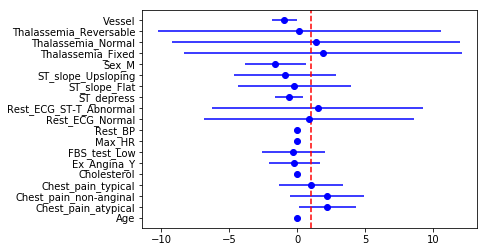

In [13]:
asymmetric_error = conf['97.5%']-conf['2.5%']

fig, ax = plt.subplots()
ax.errorbar(x=conf['Odds_ratio'],
            y=conf.index,
            xerr=asymmetric_error,fmt='bo')

plt.axvline(x=1,color='red', linestyle='--')

# Cây quyết định

Mô hình cây quyết định là một giải pháp đơn giản và lý tưởng vì nội dung của nó có thể trình bày một cách trực quan, tương đương với những lưu đồ chẩn đoán thường gặp trong thực hành lâm sàng.

In [14]:
tree_mod = tree.DecisionTreeClassifier(max_depth=3)
tree_mod.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [15]:
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'Normal'
y_train_str[y_train_str == '1'] = 'Disease'
y_train_str = y_train_str.values

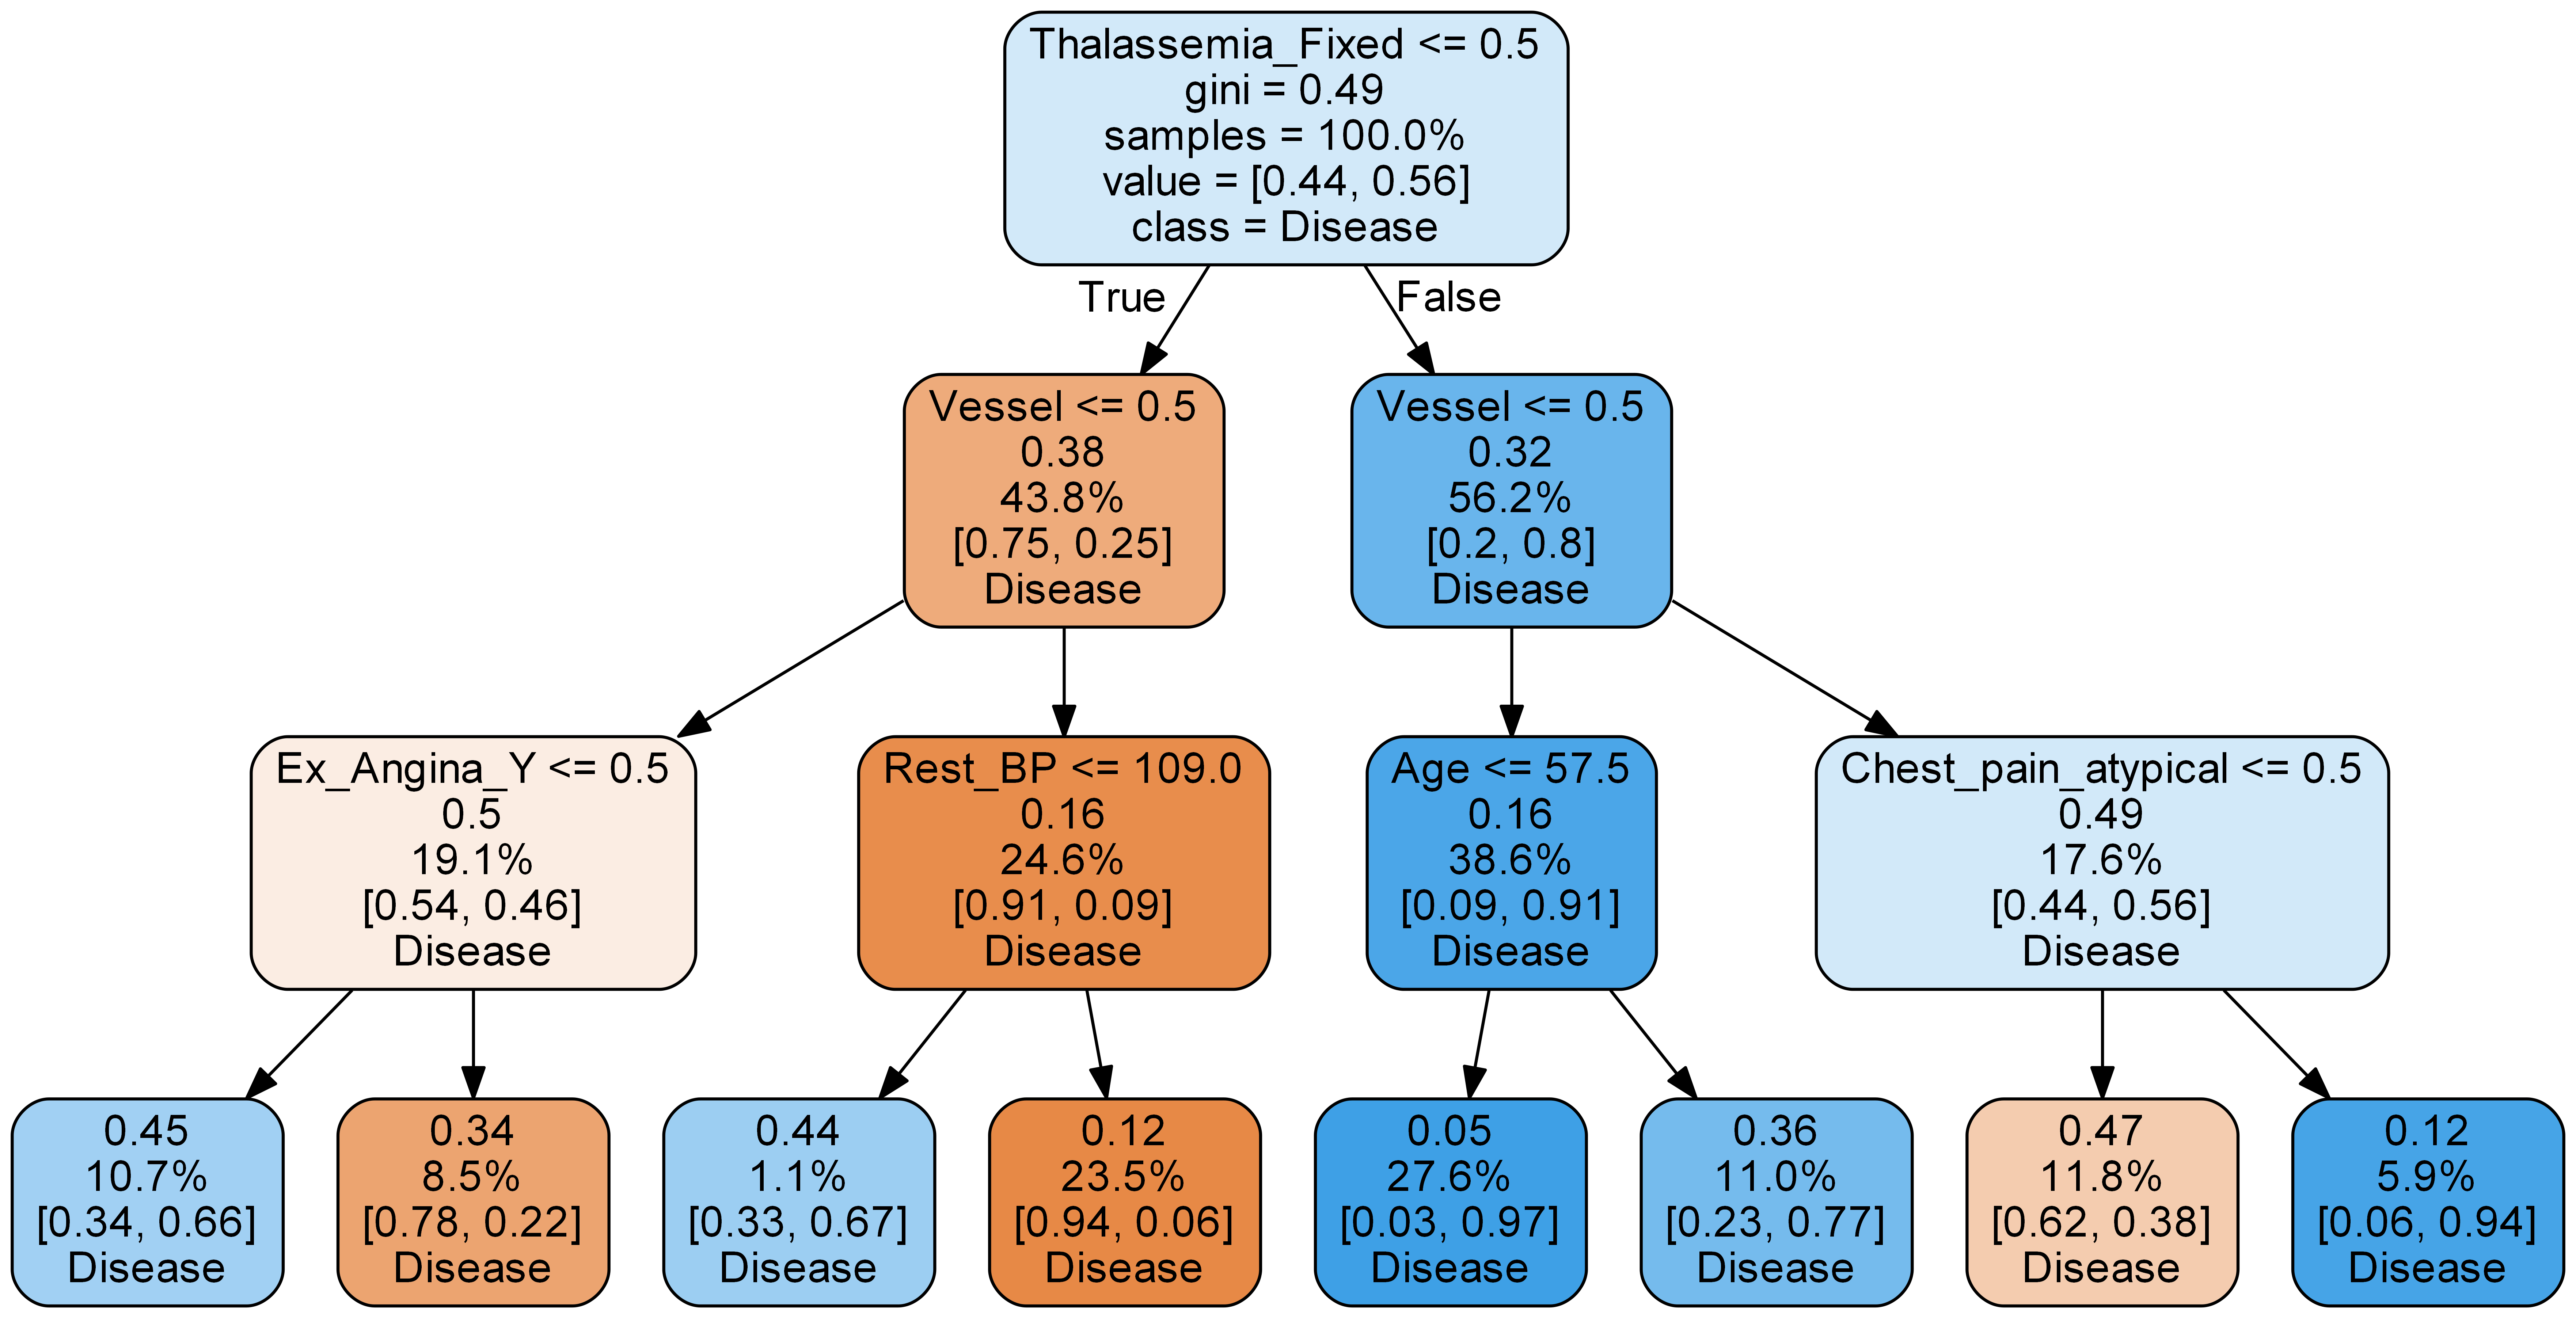

In [16]:
export_graphviz(tree_mod, 
                out_file='tree.dot',
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, 
                proportion = True, 
                label='root',
                precision = 2, 
                filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

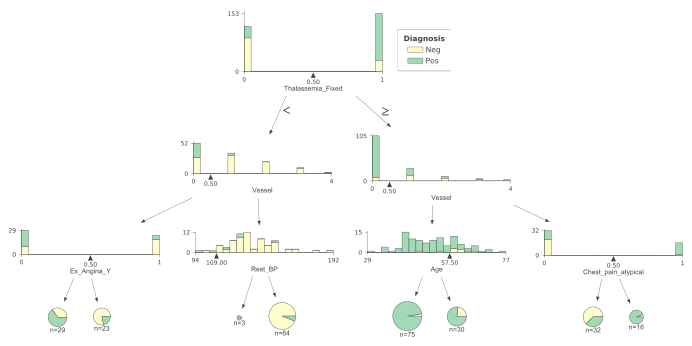

In [17]:
viz1 = dtreeviz(tree_mod, 
               X_train, y_train,
               target_name='Diagnosis',
               feature_names = feature_names,
               class_names = ['Neg','Pos'],
               histtype= 'barstacked')
viz1

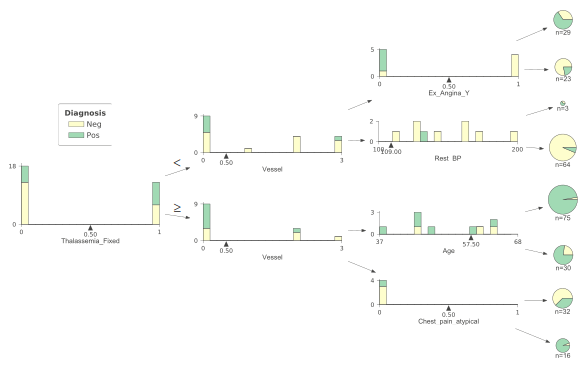

In [18]:
viz2 = dtreeviz(tree_mod, 
               X_test, y_test,
               target_name='Diagnosis',
               feature_names = feature_names,
               class_names = ['Neg','Pos'],
               histtype= 'barstacked',
              orientation='LR') 
viz2

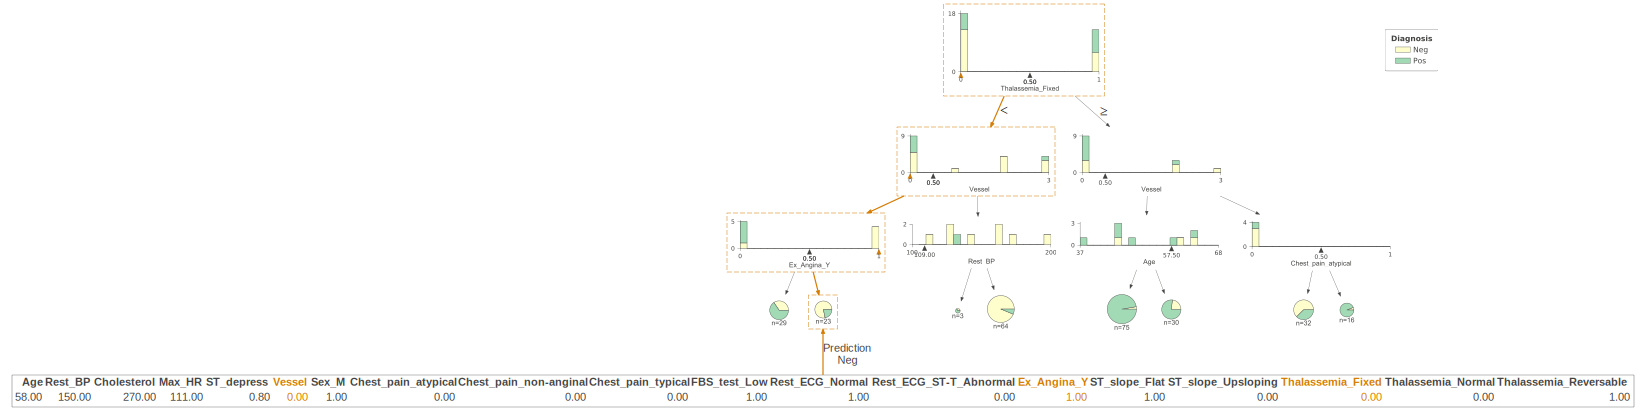

In [19]:
# Diễn giải cá thể cho case thứ 10 (negative)
viz_ind1 = dtreeviz(tree_mod, 
               X_test, y_test,
               X=X_test.iloc[10],
               target_name='Diagnosis',
               feature_names = feature_names,
               class_names = ['Neg','Pos'],
               histtype= 'barstacked') 
viz_ind1

In [20]:
y_test.iloc[10]

0

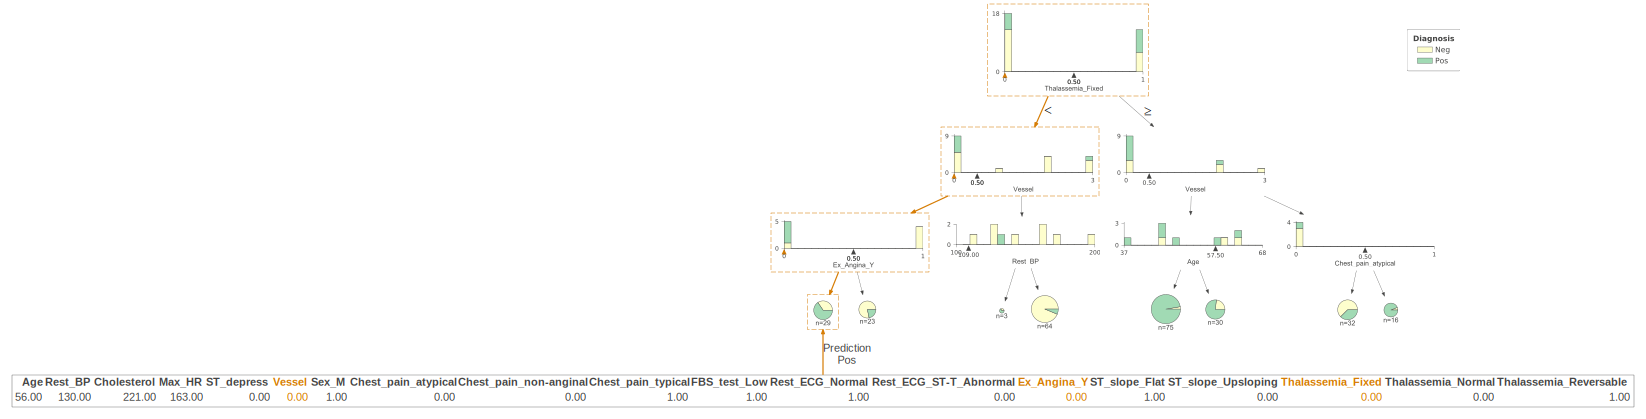

In [21]:
# Diễn giải cá thể cho case thứ 10 (positive)
viz_ind2 = dtreeviz(tree_mod, 
               X_test, y_test,
               X=X_test.iloc[20],
               target_name='Diagnosis',
               feature_names = feature_names,
               class_names = ['Neg','Pos'],
               histtype= 'barstacked') 
viz_ind2

In [22]:
y_test.iloc[20]

1

## Variable importance với mô hình Random Forest

Từ mô hình cây, chúng ta có thể phát triển một quy luật "hội chẩn" bằng mô hình Random Forest với 500 cây quyết định khác nhau từ nhiều tập dữ liệu và features ngẫu nhiên. Với mô hình RF này, ta có thể diễn giải vai trò đóng góp của từng features vào kết quả chẩn đoán (variable importance).

In [23]:
# Các hàm để tính Variable importance bằng permutation, oob_score và drop column 
# của nhóm tác giả Terence Parr, Kerem Turgutlu, Christopher Csiszar, và Jeremy Howard

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 123
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 123
        rf_.fit(X, y_train)
        o = rf_.oob_score
        imp.append(baseline - o)
    return np.array(imp)

def classifier_dropping_importances_cv(rf, X_train, y_train, k=5):
    rf_ = clone(rf)
    rf.random_state = 123
    rf_.fit(X_train, y_train)
    
    cvscore = cross_val_score(clone(rf), X_train, y_train, cv=k, scoring='accuracy')
    m_base = cvscore.mean()
    print(f"{k}-fold cross-validation accuracy {m_base:.4f}")
                              
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 123
        rf_.fit(X, y_train)
        
        cvscore = cross_val_score(clone(rf_), X, y_train, cv=5, scoring='accuracy')
        m = cvscore.mean()
        print(f"drop {col} {k}-fold cross-validation accuracy {m:.4f}")
        imp.append(m_base - m)
        
    return np.array(imp)

def oob_classifier_accuracy(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [24]:
base_rf = RandomForestClassifier(n_estimators=500,
                                 max_depth=5,
                                 n_jobs=-1,
                                 oob_score=True)

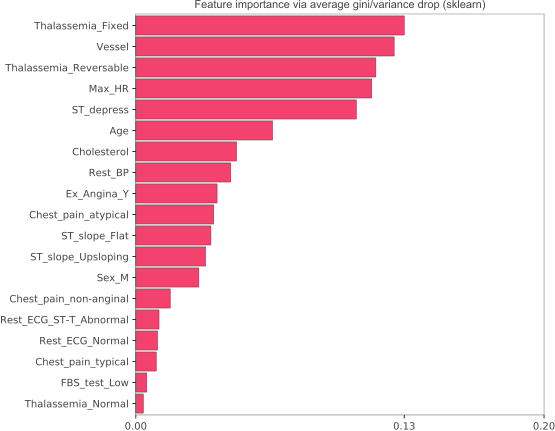

In [25]:
# Variable importance : phương pháp mặc định trong scikit-learn 

rf = clone(base_rf)
rf.fit(X_train, y_train)
I = mkdf(X_train.columns,rf.feature_importances_)            
viz3 = plot_importances(I,
                       width=8,
                       vscale=1.5,
                       imp_range=(0,0.2),
                       color='#f4426e',
                       title="Feature importance via average gini/variance drop (sklearn)")
# viz.save('cls_dflt.png')
viz3

oob accuracy 0.8161764705882353


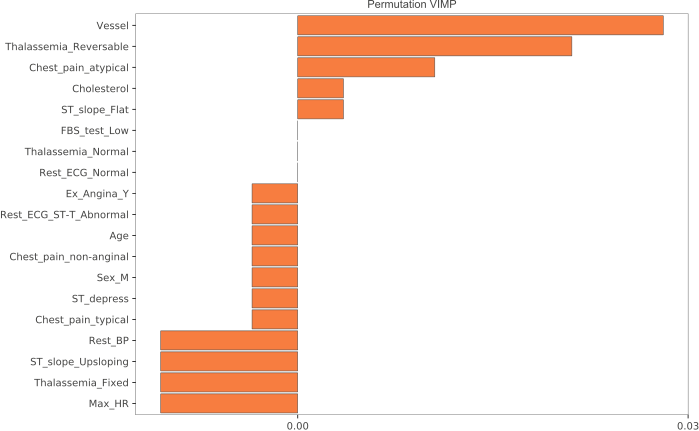

In [26]:
# Phương pháp Permutation

rf = clone(base_rf)
rf.fit(X_train, y_train)
oob = oob_classifier_accuracy(rf, X_train, y_train)
print("oob accuracy",oob)

imp = permutation_importances(rf, X_train, y_train,
                              oob_classifier_accuracy)
I = mkdf(X_train.columns,imp)

viz4 = plot_importances(I,
                       width=10,
                       vscale=1.5,
                       imp_range=(0,0.01),
                       color='#f77d40',
                       title="Permutation VIMP")
# viz.save('cls_dflt.png')
viz4

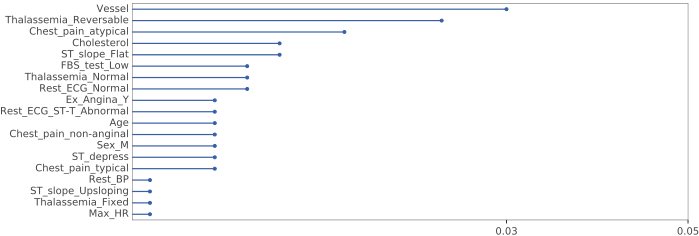

In [27]:
stemplot_importances(I, vscale=.7, width=10,imp_range=(0,0.05))

oob accuracy 0.8272058823529411


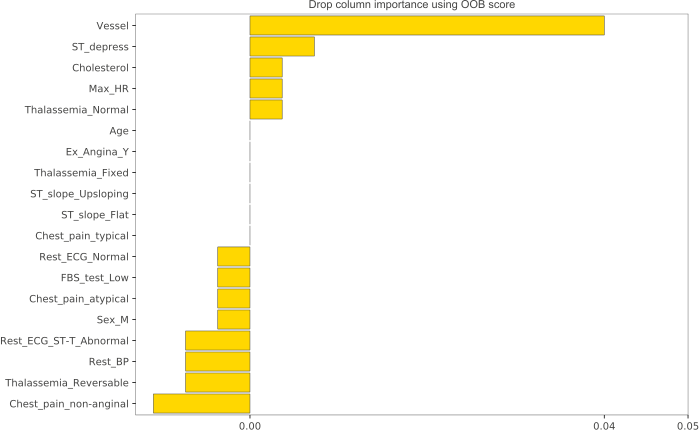

In [28]:
# Phương pháp OOB permutation

rf = clone(base_rf)
rf.fit(X_train, y_train)
oob = oob_classifier_accuracy(rf, X_train, y_train)
print("oob accuracy",oob)

I = oob_dropcol_importances(rf, X_train, y_train)

viz5 = plot_importances(I,
                       width=10,
                       vscale=1.5,
                       imp_range=(0,0.05),
                       color='gold',
                       title="Drop column importance using OOB score")
# viz.save('cls_dflt.png')
viz5

In [29]:
# Sử dụng package eli5 cho tập testset để đánh giá VIMP

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [30]:
# Diễn giải cho cá thể, thí dụ i=20, 1 case positive

eli5.explain_prediction(rf,X_train.iloc[20])

Explanation(estimator="RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n            max_depth=5, max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,\n            oob_score=True, random_state=None, verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.435102941176471, std=None, value=1.0), FeatureWeight(feature='Thalassemia_Reversable', weight=0.09880917582881037, std=None, value=1.0), FeatureWeight(feature='Thalassemia_Fixed', weight=0.09427390548352675, std=None, value=0.0), FeatureWeight(feature='ST_depress', weight=0.08373351717442373, std=None, value=1.9), FeatureWeight(feature='Vessel', weight=0.08312397254749676, std=None, value=1.0), FeatureWeight(feature='Max_HR', weight=0.06987760237738984, std=None, value=138.0), FeatureWeight(feature='Ex_Angina_Y', weight=0.035764630669383804, std=None, value=1.0), FeatureWeight(feature='Age', weight=0.032670278394627744, std=None, value=61.0), FeatureWeight(feature='Chest_pain_atypical', weight=0.023711078763417128, std=None, value=0.0), FeatureWeight(feature='Sex_M', weight=0.018024749873356442, std=None, value=1.0), FeatureWeight(feature='Chest_pain_non-anginal', weight=0.013013799913729704, std=None, value=0.0), FeatureWeight(feature='Rest_ECG_Normal', weight=0.009409304411961823, std=None, value=1.0), FeatureWeight(feature='Rest_BP', weight=0.008613814766022866, std=None, value=140.0), FeatureWeight(feature='Rest_ECG_ST-T_Abnormal', weight=0.007829524421924132, std=None, value=0.0), FeatureWeight(feature='Chest_pain_typical', weight=0.005474745538126925, std=None, value=0.0), FeatureWeight(feature='FBS_test_Low', weight=0.0023579370468488846, std=None, value=1.0), FeatureWeight(feature='Thalassemia_Normal', weight=0.0006677575695097325, std=None, value=0.0)], neg=[FeatureWeight(feature='ST_slope_Flat', weight=-0.05242199403851404, std=None, value=1.0), FeatureWeight(feature='ST_slope_Upsloping', weight=-0.03419478676334362, std=None, value=0.0), FeatureWeight(feature='Cholesterol', weight=-0.0016116066925508953, std=None, value=207.0)], pos_remaining=0, neg_remaining=0), proba=0.9342303484626187, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

## Đồ thị quan hệ bộ phận (marginalized effect)

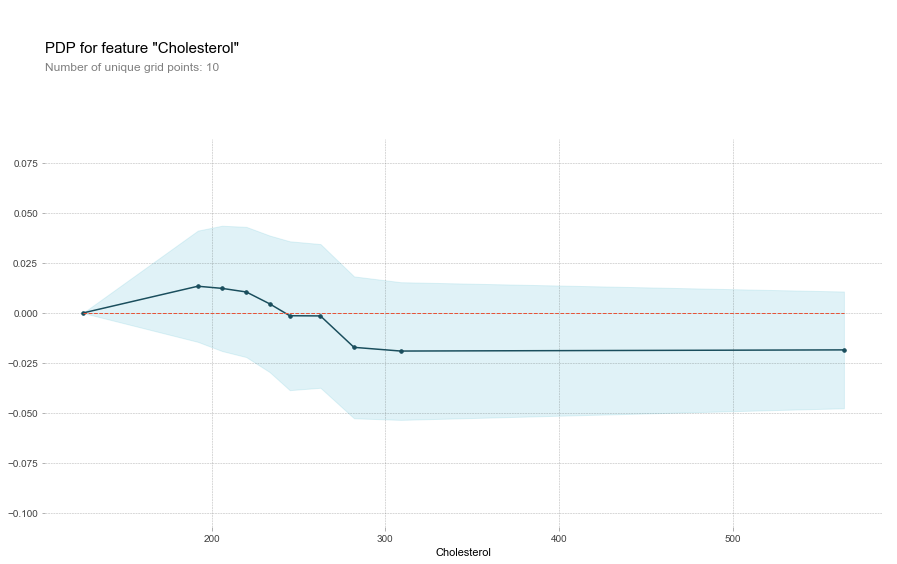

In [31]:
base_features = df.columns.values.tolist()
base_features.remove('Target')

# Khảo sát biến Cholesterol
pdp_dist = pdp.pdp_isolate(model=rf, 
                           dataset=X_train,
                           model_features=base_features, 
                           feature='Cholesterol')

pdp.pdp_plot(pdp_dist, 'Cholesterol')
plt.show()

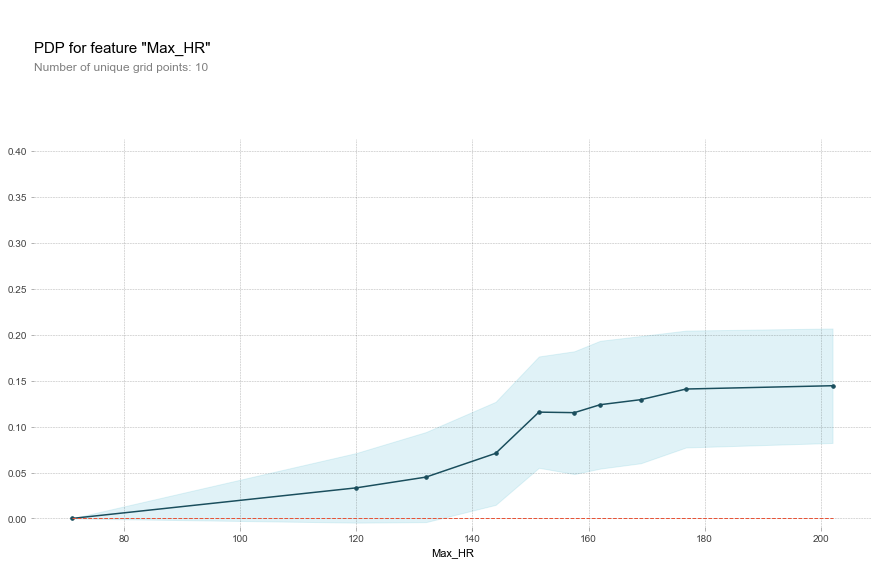

In [32]:
# Khảo sát biến Max_HR
pdp_dist = pdp.pdp_isolate(model=rf, 
                           dataset=X_train,
                           model_features=base_features, 
                           feature='Max_HR')

pdp.pdp_plot(pdp_dist, 'Max_HR')
plt.show()

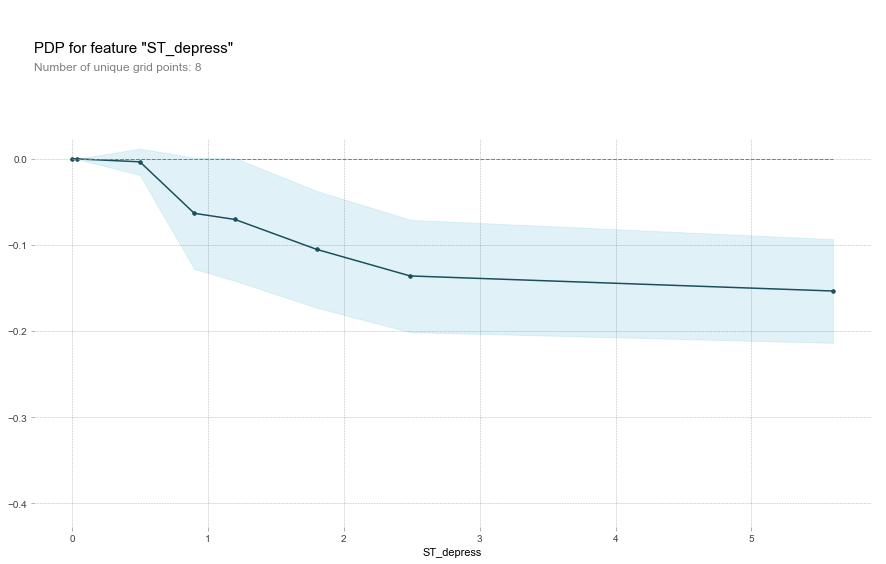

In [33]:
# Biến ST_depress 

pdp_dist = pdp.pdp_isolate(model=rf, 
                           dataset=X_train,
                           model_features=base_features, 
                           feature='ST_depress')

pdp.pdp_plot(pdp_dist, 'ST_depress')
plt.show()

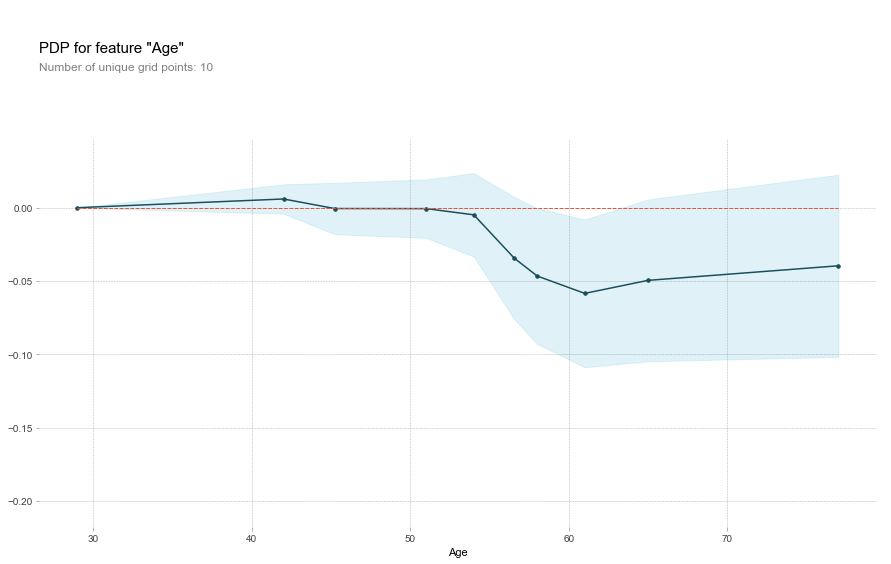

In [34]:
# tuổi

pdp_dist = pdp.pdp_isolate(model=rf, 
                           dataset=X_train,
                           model_features=base_features, 
                           feature='Age')

pdp.pdp_plot(pdp_dist, 'Age')
plt.show()

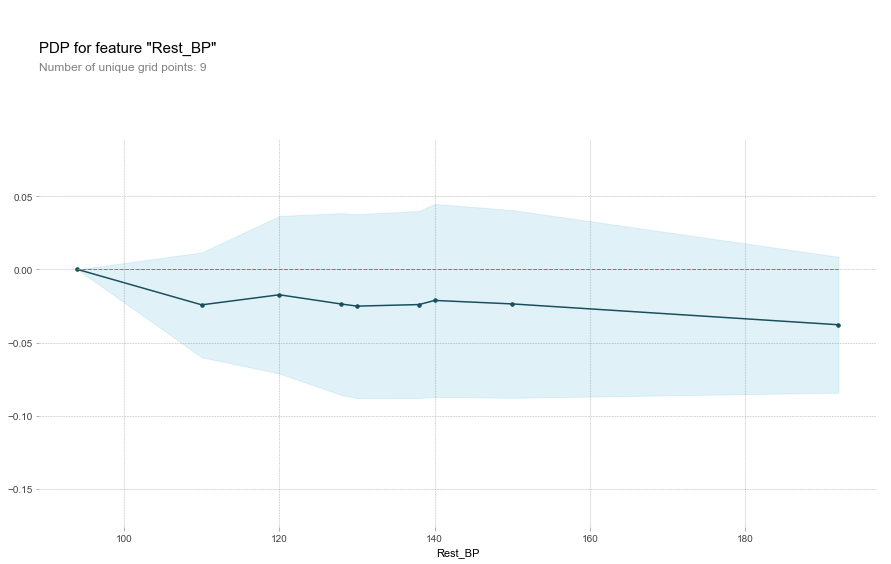

In [111]:
# Rest BP

pdp_dist = pdp.pdp_isolate(model=rf, 
                           dataset=X_train,
                           model_features=base_features, 
                           feature='Rest_BP')

pdp.pdp_plot(pdp_dist, 'Rest_BP')
plt.show()

## Tương quan bộ phận giữa 2 features bất kì

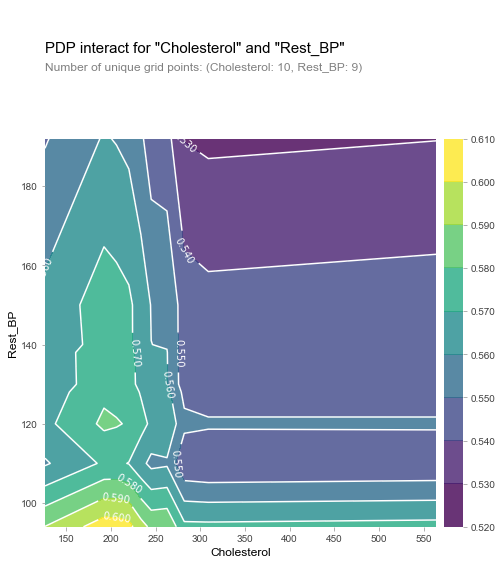

In [35]:
# Thí dụ huyết áp và cholesterol

inter  =  pdp.pdp_interact(model=rf, 
                            dataset=X_train, 
                            model_features=base_features, 
                            features=['Cholesterol','Rest_BP'])

pdp.pdp_interact_plot(pdp_interact_out=inter, 
                      feature_names=['Cholesterol','Rest_BP'], 
                      plot_type='contour')

plt.show()

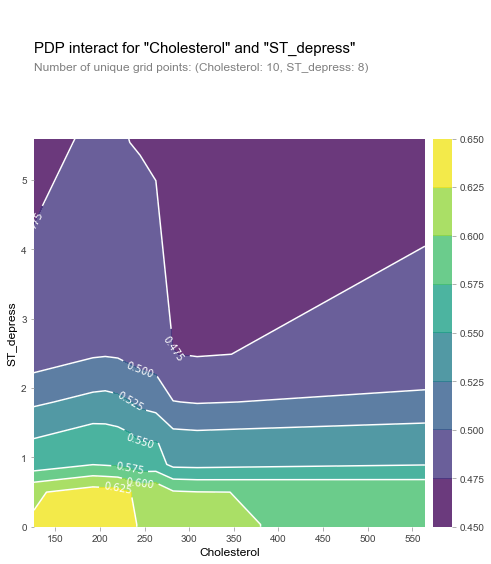

In [36]:
# Cholesterol và ST chênh

inter  =  pdp.pdp_interact(model=rf, 
                            dataset=X_train, 
                            model_features=base_features, 
                            features=['Cholesterol','ST_depress'])

pdp.pdp_interact_plot(pdp_interact_out=inter, 
                      feature_names=['Cholesterol','ST_depress'], 
                      plot_type='contour')

plt.show()

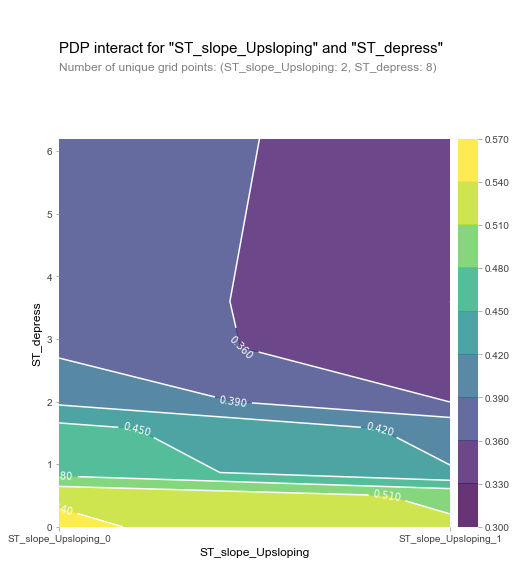

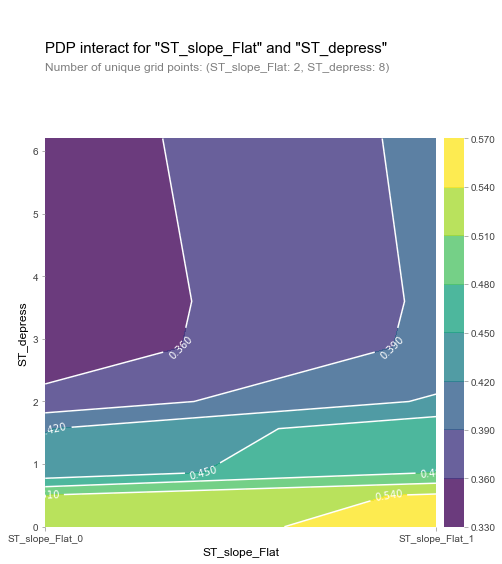

In [38]:
inter1  =  pdp.pdp_interact(model=rf, 
                            dataset=X_test, 
                            model_features=base_features, 
                            features=['ST_slope_Upsloping', 'ST_depress'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                      feature_names=['ST_slope_Upsloping', 'ST_depress'], 
                      plot_type='contour')

plt.show()

inter2  =  pdp.pdp_interact(model=rf, 
                            dataset=X_test, 
                            model_features=base_features, 
                            features=['ST_slope_Flat', 'ST_depress'])

pdp.pdp_interact_plot(pdp_interact_out=inter2, 
                      feature_names=['ST_slope_Flat', 'ST_depress'], 
                      plot_type='contour')


plt.show()

## Phương pháp LIME cho mọi algorithm

LIME là tên viết tắt của phương pháp Local Interpretable Model-Agnostic Explanations, tạm dịch : « Phép diễn giải cục bộ cho mọi mô hình», được giới thiệu lần đầu tiên năm 2016 trong một bài báo của 3 data scientists tại ĐH Washinton là Marco Tulio Ribeiro, Sameer Singh và Carlos Guestrin. https://arxiv.org/abs/1602.04938, ứng dụng đầu tiên trong Python.

In [39]:
# tạo explainer

explainer = lime.lime_tabular.LimeTabularExplainer(X_test,
                                                   feature_names=feature_names, 
                                                   class_names=['Neg','Pos'], 
                                                   discretize_continuous=False)

In [40]:
# Diễn giải mô hình RF cho 1 case bất kì (i) trong testset, thí dụ i=10

exp = explainer.explain_instance(X_test.iloc[10], 
                                 rf.predict_proba, 
                                 num_features=19)

In [83]:
exp.show_in_notebook(show_table=True, 
                     show_all=True)

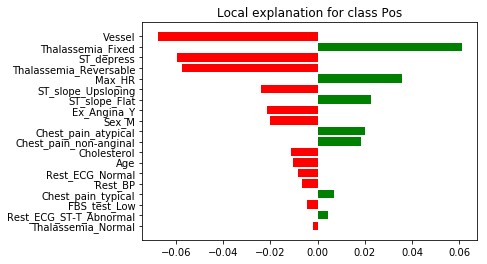

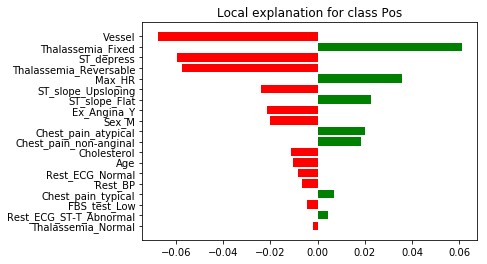

In [41]:
exp.as_pyplot_figure()

In [42]:
exp.as_list()

[('Vessel', -0.06788775225677383),
 ('Thalassemia_Fixed', 0.06118711091859422),
 ('ST_depress', -0.05973748326440033),
 ('Thalassemia_Reversable', -0.0576706938841689),
 ('Max_HR', 0.03595933248411026),
 ('ST_slope_Upsloping', -0.024072232222946167),
 ('ST_slope_Flat', 0.022722726299367987),
 ('Ex_Angina_Y', -0.021493679850904075),
 ('Sex_M', -0.020377498507796698),
 ('Chest_pain_atypical', 0.020280754064173942),
 ('Chest_pain_non-anginal', 0.018430735647537267),
 ('Cholesterol', -0.011309525327212914),
 ('Age', -0.01036687845529982),
 ('Rest_ECG_Normal', -0.008410374692234478),
 ('Rest_BP', -0.00679944598887512),
 ('Chest_pain_typical', 0.00674283710730909),
 ('FBS_test_Low', -0.004426194379666356),
 ('Rest_ECG_ST-T_Abnormal', 0.004198934665652544),
 ('Thalassemia_Normal', -0.0018883398884412417)]

## Shapley score

Phương pháp này dựa vào sự ước tính Shapley score, là một chỉ số có nguồn gốc từ lý thuyết học thuyết trò chơi (Game theory):
https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d

Ta sử dụng 1 công cụ chuyên biệt cho họ mô hình cây, bao gồm Random forest adaboost và XGboost, đó là TreeExplainer từ package shap: https://github.com/slundberg/shap

In [43]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

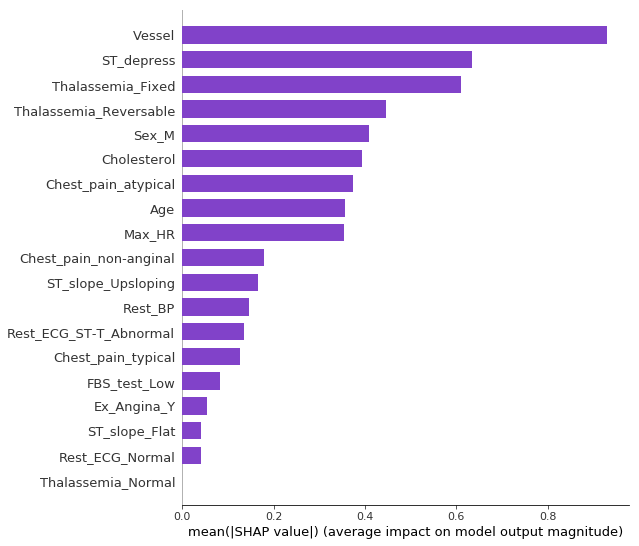

In [45]:
shap.summary_plot(shap_values, 
                  X_train, 
                  plot_type="bar",
                  color="#8142c9")

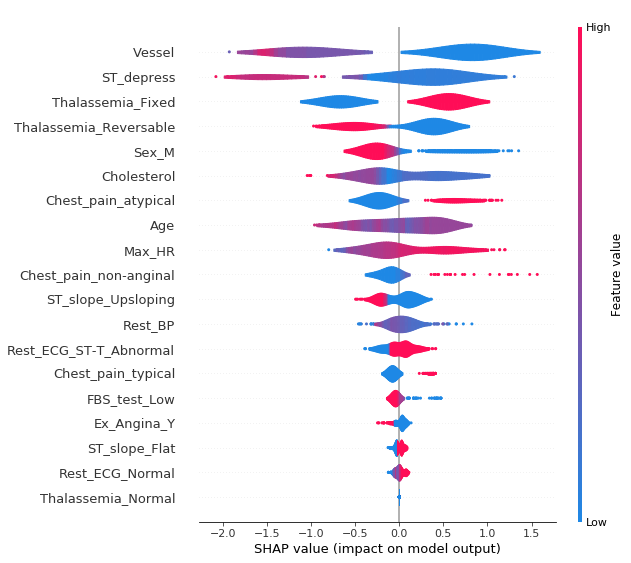

In [46]:
shap.summary_plot(shap_values, 
                  X_train,
                  plot_type="violin")

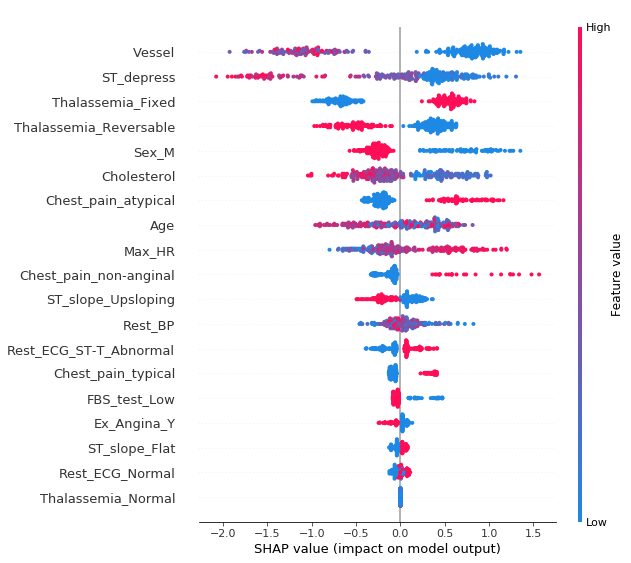

In [47]:
shap.summary_plot(shap_values, X_train)

## Diễn giải cho từng cá thể

In [48]:
# hàm vẽ biểu đồ cho cá thể
def Individual_explain(model, case):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(case)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], 
                           shap_values[1],case)

In [49]:
case = X_test.iloc[10,:].astype(float)
print(y_test.iloc[10], xgb_model.predict(X_test)[10])
Individual_explain(rf, case)

0 0


In [50]:
case = X_test.iloc[20,:].astype(float)
print(y_test.iloc[20], xgb_model.predict(X_test)[20])
Individual_explain(rf, case)

1 1


## Diễn giải cho hàng loạt cá thể

In [51]:
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values, X_train)